# Optimizing Game Theory Algorithms for Graph-Based Games

## Import sources and graph creation

In [ ]:
import networkx as nx
import numpy as np
from random import random, randint, uniform
import time
from math import factorial
from itertools import combinations
import matplotlib.pyplot as plt
from typing import List
from itertools import permutations
import networkx.algorithms.approximation.treewidth as tw
import random

In [ ]:
# @title execution parameters
# these 4 variables determine what points will be executed.
# You can choose whatever you prefer
POINT_1 = True
POINT_2 = True
POINT_3 = True
POINT_4 = True

#set this to true for running experiments, false otherwise
EXPERIMENTS = True

#set this to true if you want to use the prepared blocks for testing the sol.
SINGLE_BENCHMARK = False

In [ ]:

G=nx.Graph()
nodes = ['s', 't', '1', '2', '3', '4']
edges = [('s', '1'), ('s', '2'), ('1', '3'), ('1', '4'), #('3','4'),('3','2'),
         ('2', '4'), ('3', 't'), ('4', 't')]
G.add_nodes_from(nodes)
G.add_edges_from(edges)

print(f"Nodes: {G.nodes()}")
print(f"Edges: {G.edges()}")

Nodes: ['s', 't', '1', '2', '3', '4']
Edges: [('s', '1'), ('s', '2'), ('t', '3'), ('t', '4'), ('1', '3'), ('1', '4'), ('2', '4')]


In [ ]:
# @title Random graph generator
# generates a random graph starting from the fixed parameters in innput.
# Used in all the assignments for both correctness checking and benchmarking
def generate_random_graph_from_parameters(num_nodes: int, edge_density: float,
                                          outcoming_edges_from_s: int,
                                          incoming_edges_on_t: int):
  min_node_name = 1
  nodes = [str(x) for x in range(min_node_name,num_nodes+1)]
  nodes.append('s')
  nodes.append('t')
  G=nx.Graph()
  G.add_nodes_from(nodes)
  #print(f"adding nodes to graph: {nodes}")
  # add a number of edges according to density where density is a float
  # between 0 and 1 which. A graph with density 0 is a graph without edges,
  # a graph with density 1 is a graph with n(n-1)/2 eges when edges = num_nodes
  max_num_edges = (num_nodes*(num_nodes -1))/2
  #print(f"Max num edges: {max_num_edges}")
  for i in range(int(max_num_edges * edge_density)):
    # guess two nodes and add the edge
    # if edge was already added guess again -I want the exact num of edges in G
    u = nodes[randint(min_node_name-1,num_nodes-1)]
    v = nodes[randint(min_node_name-1,num_nodes-1)]
    edge = (u, v)
    while G.has_edge(edge[0], edge[1]) or edge[0] == edge[1]:
      u = nodes[randint(min_node_name-1,num_nodes-1)]
      v = nodes[randint(min_node_name-1,num_nodes-1)]
      edge = (u, v)
    G.add_edge(edge[0], edge[1])
    #print(f"Adding edge {edge[0]}, {edge[1]}")

  for i in range(outcoming_edges_from_s):
    v = nodes[randint(min_node_name-1,num_nodes-1)]
    while G.has_edge('s', v):
      v = nodes[randint(min_node_name-1,num_nodes-1)]
    G.add_edge('s', v)
    #print(f"Adding edge from s towards {v}")

  for i in range(incoming_edges_on_t):
    u  = nodes[randint(min_node_name-1,num_nodes-1)]
    while G.has_edge(u, 't'):
      u = nodes[randint(min_node_name-1,num_nodes-1)]
    G.add_edge(u, 't')
    #print(f"Adding edge toward t from {u}")
  return G


In [ ]:
# @title Materialized powerset
def powerset(List):
    subs = [frozenset(j) for i in range(len(List)) for j in combinations(List, i+1)]
    subs += [frozenset()]
    return subs

In [ ]:
# @title Generation example

# num_nodes = randint(10, 15)
# density = random.uniform(0.1, 1.0)
# print(f"Generating node with num nodes: {num_nodes} and density: {density}")
# #TODO these names are not appropriate
# edges_outcoming_from_s = randint(2, 3)
# edges_incoming_on_t = randint(2, 3)
# G = generate_random_graph_from_parameters(num_nodes, density, 2, 2)
# print(f"The graph contains {len(list(G.neighbors('s')))} edges from s and {len(list(G.neighbors('t')))} edges from t")
# print(f"The graph has: {len(list(G.nodes()))} nodes and {len(list(G.edges()))} edges")



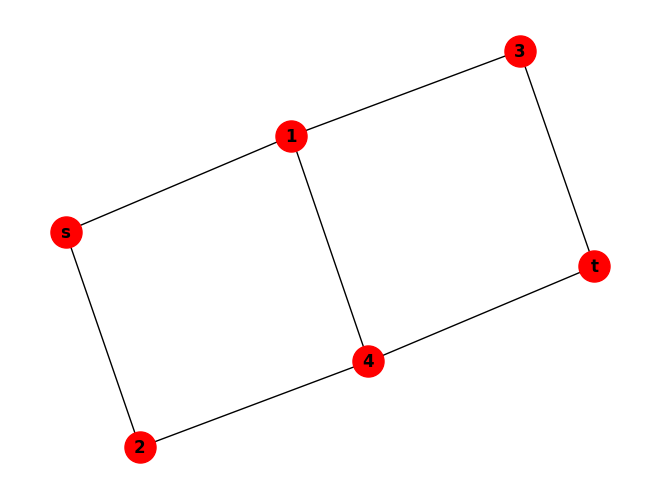

In [ ]:
# @title Graph plot
nx.draw(G, with_labels = True, font_weight='bold', node_size = 500, node_color = 'red')

# Assignment 1

Assume that forming a path connecting s and t lead to a reward of 100$. Then,compute the Shapley value associated with the agents in {1,2,……,n} as a fair way to distribute that reward among the agents in {1,2,……, n}, which in particular encourages cooperation

In [ ]:
# @title compute characteristic function for graph G
if POINT_1:
  def compute_characteristic_function(G, naive: bool):
    characteristic_function: dict = {}
    all_nodes = list(G.nodes())
    all_nodes.remove('s')
    all_nodes.remove('t')
    all_coalitions = powerset(all_nodes)
    # for every coalition, modify the graph such that
    # it contains only the nodes and the edges in such coalitions
    # and assign a value to CF according to the path formation
    for coalition in all_coalitions:
      removed_nodes = []
      for node in all_nodes:
        if node not in coalition:
          removed_nodes.append(node)

      removed_edges = list(G.edges(removed_nodes))
      G.remove_nodes_from(removed_nodes)
      #check that a path s-t exists in the subgraph
      #made of the nodes in the subset and the edges
      #incident to such nodes
      if nx.has_path(G, 's', 't'):
        characteristic_function[coalition] = 100
      else:
        if naive:
          characteristic_function[coalition] = 0
      G.add_nodes_from(removed_nodes)
      for e in removed_edges:
        G.add_edge(e[0], e[1])
    return characteristic_function

In [ ]:
# @title characteristic function from the example
if POINT_1:
  characteristic_function: dict = {frozenset(): 0, frozenset({"1"}): 0, frozenset({"2"}): 0, frozenset({"3"}): 0, frozenset({"4"}): 0,
                                  frozenset({"1", "2"}): 0, frozenset({"1", "3"}): 100, frozenset({"1", "4"}): 100,
                                  frozenset({"2", "3"}): 0, frozenset({"2", "4"}): 100, frozenset({"3", "4"}): 0,
                                  frozenset({"1", "2", "4"}): 100, frozenset({"1", "3", "4"}): 100, frozenset({"2", "3", "1"}): 100,
                                  frozenset({"2", "3", "4"}): 100, frozenset({"1", "2", "3", "4"}): 100}

In [ ]:
# @title Shapley value with optimized characteristic function
if POINT_1:
  def shapley_value(player, characteristic_function):
      player = frozenset([player])
      player_list = max(characteristic_function)
      N = len(player_list)
      shapley_val = 0
      for coalition in characteristic_function:
          S = len(coalition)
          if S == 0:
            continue
          coalition_without_player = coalition - player
          marginal_contribution = 0
          if coalition_without_player not in characteristic_function:
              marginal_contribution = 100

          shapley_val += ((factorial(N - S) * factorial(S - 1)) / factorial(N)) * marginal_contribution
      return round(shapley_val, 10)

  def shapley(characteristic_function, all_nodes):
      return {player: shapley_value(player, characteristic_function) for player in list(all_nodes)}

In [ ]:
# @title Shapley value with standard characteristic from lab solutions
if POINT_1:
  # We now implement the Shapley value for a given player, using the second equation
  def shapley_value_lab(player, characteristic_function):
      player_list = max(characteristic_function)
      player = set([player])
      N = len(player_list)
      coalitions = powerset(player_list)
      shapley_val = 0
      for coalition in coalitions:
          S = len(coalition)
          if S == 0:
            continue
          marginal_contribution = characteristic_function[coalition] - (characteristic_function[coalition - player] if len(coalition - player) > 0 else 0)
          shapley_val += ((factorial(N - S) * factorial(S - 1)) / factorial(N)) * marginal_contribution
      return round(shapley_val, 10)

  # This function returns a dictionary with the Shapley value for each player
  def shapley_lab(characteristic_function):
      # To get the grand coalition from the characteristic function, we can use the function max
      return {player: shapley_value_lab(player, characteristic_function) for player in max(characteristic_function)}

In [ ]:
# @title compare shapley value result with tolerance
if POINT_1:
  def compare_dictionaries(dict1, dict2, tolerance=0):
      if set(dict1.keys()) != set(dict2.keys()):
          return False

      for key in dict1:
          if isinstance(dict1[key], int) and isinstance(dict2[key], int):
              if abs(dict1[key] - dict2[key]) > tolerance:
                  return False
          elif dict1[key] != dict2[key]:
              return False

      return True

In [ ]:
# @title Inappropriate benchmarking
if POINT_1:
  import random
  def make_comparison(num_comparisons: int):
    smart_solved_instances_times = []
    naive_solved_instances_times = []

    for i in range(num_comparisons):
      # create a random graph with fixed parameters
      num_nodes = randint(13, 18)
      density = random.uniform(0.1, 0.5)
      # TODO these names are not appropriate
      # add edges of the type {s, n} and {n, t} in the graph
      # (these { indicate the set repr. of edges
      # which is more appropriate in undirected graphs)
      edges_outcoming_from_s = randint(2, 3)
      edges_incoming_on_t = randint(2, 3)
      print(f"Generating node with num nodes: {num_nodes} and density: {density}")
      G = generate_random_graph_from_parameters(num_nodes, density, edges_outcoming_from_s, edges_incoming_on_t)
      all_nodes = list(G.nodes())
      all_nodes.remove('s')
      all_nodes.remove('t')
      characteristic_function_smart = compute_characteristic_function(G, False)
      start_time = time.time()
      shapley_values_smart = shapley(characteristic_function_smart, all_nodes)
      end_time = time.time()
      print(shapley_values_smart)
      smart_solved_instance_time = end_time-start_time
      print(f"Smart computation took {smart_solved_instance_time}")

      characteristic_function_naive = compute_characteristic_function(G, True)
      start_time = time.time()
      shapley_values_naive = shapley_lab(characteristic_function_naive)
      end_time = time.time()
      print(shapley_values_naive)
      naive_solved_instance_time = end_time-start_time
      print(f"Naive computation took {naive_solved_instance_time}")

      if not compare_dictionaries(shapley_values_smart, shapley_values_naive, tolerance = 0.0001):
        print("ERROR: Shapley values for the two implementations do not coincide")
        #for debugging purposes
        #return G
      else:
        smart_solved_instances_times.append(smart_solved_instance_time)
        naive_solved_instances_times.append(naive_solved_instance_time)

    print("ALL DONE! No errors found")
    return (smart_solved_instances_times, naive_solved_instances_times)




In [ ]:
if POINT_1 and EXPERIMENTS:
  num_comparisons = 20
  results = make_comparison(num_comparisons)

Generating node with num nodes: 16 and density: 0.3224014262526028
{'1': 0.0, '2': 0.2572427572, '3': 0.1598401598, '4': 0.2752802753, '5': 17.4975024975, '6': 0.0083250083, '7': 2.5588300588, '8': 0.2608502609, '9': 2.1403596404, '10': 6.3683538684, '11': 0.3932178932, '12': 61.9635919636, '13': 4.7594072594, '14': 0.1237651238, '15': 3.035020535, '16': 0.1984126984}
Smart computation took 1.0215845108032227
{'3': 0.1598401598, '11': 0.3932178932, '14': 0.1237651238, '2': 0.2572427572, '7': 2.5588300588, '8': 0.2608502609, '13': 4.7594072594, '15': 3.035020535, '10': 6.3683538684, '12': 61.9635919636, '5': 17.4975024975, '1': 0.0, '16': 0.1984126984, '4': 0.2752802753, '9': 2.1403596404, '6': 0.0083250083}
Naive computation took 6.033766269683838
Generating node with num nodes: 18 and density: 0.4723765052586498
{'1': 0.0045787546, '2': 0.327034077, '3': 0.327034077, '4': 0.0650738151, '5': 15.3592241092, '6': 0.0295537796, '7': 0.0745088245, '8': 0.327034077, '9': 0.0295537796, '10':

In [ ]:
# @title Block for checking solution after submission
# TODO just define your graph here and remove all comments
# if POINT_1 and SINGLE_BENCHMARK:
  # G=nx.Graph()
  # nodes = ['s', 't', '1', '2', '3', '4']
  # edges = [('s', '1'), ('s', '2'), ('1', '3'), ('1', '4'), #('3','4'),('3','2'),
  #         ('2', '4'), ('3', 't'), ('4', 't')]
  # G.add_nodes_from(nodes)
  # G.add_edges_from(edges)

  # print(f"Nodes: {G.nodes()}")
  # print(f"Edges: {G.edges()}")

  # characteristic_function_smart = compute_characteristic_function(G, False)
  # start_time = time.time()
  # shapley_values_smart = shapley(characteristic_function_smart)
  # end_time = time.time()
  # print(shapley_values_smart)
  # smart_solved_instance_time = end_time-start_time
  # print(f"Smart computation took {smart_solved_instance_time}")

  # characteristic_function_naive = compute_characteristic_function(G, True)
  # start_time = time.time()
  # shapley_values_naive = shapley_lab(characteristic_function_naive)
  # end_time = time.time()
  # print(shapley_values_naive)
  # naive_solved_instance_time = end_time-start_time
  # print(f"Naive computation took {naive_solved_instance_time}")

  # if not compare_dictionaries(shapley_values_smart, shapley_values_naive, tolerance = 0.0001):
  #   print("ERROR: Shapley values for the two implementations do not coincide")
  # else:
  #   print("ALL DONE! No errors found")

1.5144763350486756
10.601771998405457


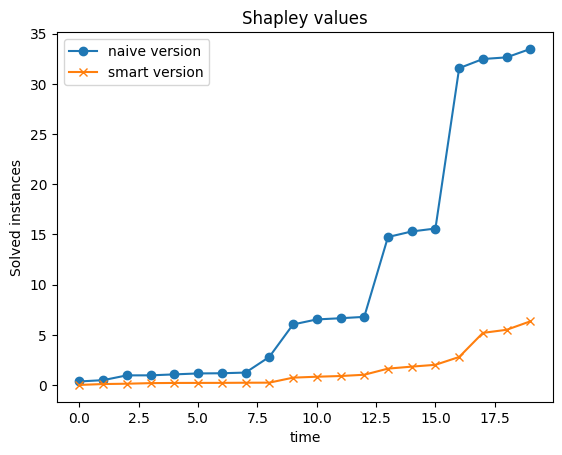

In [ ]:
# @title Cactus plot of results
from statistics import mean
if POINT_1 and EXPERIMENTS:
  x_smart = results[0]
  y = [i for i in range(num_comparisons)]

  x_naive = results[1]

  x_smart.sort()
  x_naive.sort()

  print(mean(x_smart))
  print(mean(x_naive))

  plt.plot(y, x_naive, marker='o', linestyle='-', label='naive version')
  plt.plot(y, x_smart,  marker='x', linestyle='-', label='smart version')

  plt.ylabel('Solved instances')
  plt.xlabel('time')
  plt.title('Shapley values')

  plt.legend()

  plt.show()


In [ ]:
# @title Check that the two created characteristic function represent the same thing
if POINT_1:
  # the naive and smart characteristic function should have the same meaning
  def check_characteristic_functions(characteristic_function, characteristic_function_1):
    for coalition in characteristic_function.keys():

      if coalition in characteristic_function_1:
        if 100 != characteristic_function_1[coalition]:
          #print("Error")
          return False
      else:
        if characteristic_function[coalition] != 0:
          #print("Error")
          return False
    return True

# Assignment 2

In [ ]:
# @title Compute always cooperating players as the players with <=2 neighbours
if POINT_2:
  # nodes with less than 3 neighbours are always cooperating
  def compute_always_cooperating_players(G):
    always_cooperating_players = []
    all_nodes = list(G.nodes())
    all_nodes.remove('s')
    all_nodes.remove('t')

    source_and_destination = ['s', 't']
    removed_edges = list(G.edges(source_and_destination))
    G.remove_nodes_from(source_and_destination)

    nodes_to_degree = dict(G.degree())
    for node in all_nodes:
      if nodes_to_degree[node] <= 2:
        always_cooperating_players.append(node)

    G.add_nodes_from(source_and_destination)
    for e in removed_edges:
      G.add_edge(e[0], e[1])
    return always_cooperating_players

In [ ]:
# @title compute payoffs for players in G
if POINT_2:
  def compute_payoffs(G, always_cooperating_players, naive: bool):
    payoffs: dict = {}
    all_nodes = list(G.nodes())
    all_nodes.remove('s')
    all_nodes.remove('t')
    all_strategy_profiles = powerset(all_nodes)

    all_nodes_int = [int(node) for node in all_nodes]
    all_nodes_int.sort()

    for strategy_profile in all_strategy_profiles:
      # do not compute payoffs for stategies in which always
      # cooperating players are defecting because these will never be equilibria
      # Or better: they may be equlibria, but so will be also the strategy in
      # which such player is cooperating instead of defecting. Therefore we can
      # remove these kind of strategies without loss of soundness or
      # completeness for the proposed task
      if not naive:
        skip_strategy = False
        for player in always_cooperating_players:
          if player not in strategy_profile:
            skip_strategy = True
            break

        if len(strategy_profile) == 0 and len(always_cooperating_players) > 0:
          skip_strategy = True

        if skip_strategy:
          continue

      removed_nodes = []
      #if coalition not in characteristic function
      for node in all_nodes:

        if node not in strategy_profile:
          removed_nodes.append(node)

      removed_edges = list(G.edges(removed_nodes))
      G.remove_nodes_from(removed_nodes)
      #check that a path s-t exists in the subgraph
      #made of the nodes in the subset and the edges
      #incident to such nodes

      payoffs[strategy_profile] = []
      if nx.has_path(G, 's', 't'):
        #set 1 for players that have not more than 2 neighbours cooperating
        # -1 otherwise
        for player in all_nodes_int:
          player = str(player)
          if player in strategy_profile:
            neigh_cooperating = list(G.neighbors(player))
            num_neigh_cooperating = len(neigh_cooperating)
            #s and t are not considered in the count
            if 's' in neigh_cooperating:
              num_neigh_cooperating -= 1
            if 't' in neigh_cooperating:
              num_neigh_cooperating -= 1

            #print("WE", len(list(G.neighbors(player))))
            #constraint violated
            if num_neigh_cooperating > 2:
              payoffs[strategy_profile].append(-1)
            #cooperation and path forms
            else:
              payoffs[strategy_profile].append(1)
            #no cooperation but path forms
          else:
            payoffs[strategy_profile].append(-0.5)
        #for all players in the game
      else:
        for player in all_nodes_int:
          # no path but cooperating
          #payoffs[strategy_profile].append(-1)
          player = str(player)
          if player in strategy_profile:
            neigh_cooperating = list(G.neighbors(player))
            num_neigh_cooperating = len(neigh_cooperating)
            #s and t are not considered in the count
            if 's' in neigh_cooperating:
              num_neigh_cooperating -= 1
            if 't' in neigh_cooperating:
              num_neigh_cooperating -= 1
            if num_neigh_cooperating > 2:
              payoffs[strategy_profile].append(-1)
            else:
              payoffs[strategy_profile].append(0)
          # # no path and defecting
          else:
            payoffs[strategy_profile].append(-0.5)
      G.add_nodes_from(removed_nodes)
      for e in removed_edges:
        G.add_edge(e[0], e[1])
    #payoffs[frozenset()] = [-0.5 for i in range(len(list(G.nodes())))]
    return payoffs

In [ ]:
# @title compute Nash Equilibrium - Naive approach
if POINT_2:
  def compute_nash_equilibrium_naive(G, payoffs, all_strategy_profiles, return_all=False):
    all_nodes = list(G.nodes())
    all_nodes.remove('s')
    all_nodes.remove('t')
    all_equilibria = []
    for strategy_profile in all_strategy_profiles:
      best_strategy = True
      for player in all_nodes:
        player_set = frozenset([player])
        if player in strategy_profile:
          changed_strategy = strategy_profile - player_set
        else:
          changed_strategy = strategy_profile.union(player_set)

        if payoffs[changed_strategy][int(player)-1] > payoffs[strategy_profile][int(player)-1]:
          best_strategy = False
          break
      #profile is not best strategy for some player and hence it cannot be an eq.
      #if no player stopped the inner for (for every player the profile was
      # a best response), then profile is an equilibrium
      if best_strategy:
        if not return_all:
          return (True, strategy_profile)
        else:
          all_equilibria.append(strategy_profile)
    return (len(all_equilibria) > 0, all_equilibria)


In [ ]:
# @title compute Nash Equilibrium - A smarter approach
if POINT_2:
  def compute_nash_equilibrium_smart(G, payoffs, always_cooperating_players, all_strategy_profiles, return_all=False):
    all_nodes = list(G.nodes())
    all_nodes.remove('s')
    all_nodes.remove('t')
    all_equilibria = []
    # check only strategies for which a payoff is given
    # N.B. strategy profiles not in payoffs are not equilibria
    non_always_cooperating_players = frozenset(all_nodes) - frozenset(always_cooperating_players)

    # trivial Nash equilibrium when no player has more than two neighbours
    # and therefore anyone cooperates
    if non_always_cooperating_players == frozenset():
      return (True, frozenset(all_nodes))

    for strategy_profile in payoffs.keys():
      best_strategy = True
      # do not check best response condition for always cooperating player
      # since cooperating is a dominant strategy for them and only
      # strategy profiles with them cooperating are given
      for player in non_always_cooperating_players:
        player_set = frozenset([player])
        if player in strategy_profile:
          changed_strategy = strategy_profile - player_set
        else:
          changed_strategy = strategy_profile.union(player_set)
        if payoffs[changed_strategy][int(player)-1] > payoffs[strategy_profile][int(player)-1]:
          #print(f"strategy {changed_strategy} is better w.r.t. {strategy_profile} for player{player}")
          best_strategy = False
          break
      #profile is not best strategy for some player and hence it cannot be an eq.
      #if no player stopped the inner for (for every player the profile was
      # a best response), then profile is an equilibrium
      if best_strategy:
        if not return_all:
          return (True, strategy_profile)
        else:
          all_equilibria.append(strategy_profile)
    return (len(all_equilibria) > 0, all_equilibria)

In [ ]:
# @title Benchmarking
if POINT_2:
  import random

  def make_comparison_nash_eq(num_comparisons: int):
    smart_solved_instances_times = []
    naive_solved_instances_times = []
    smart_to_check_strategy_profiles = []
    naive_to_check_strategy_profiles = []
    for i in range(num_comparisons):
      # create a random graph with fixed parameters
      num_nodes = randint(15, 18)
      density = random.uniform(0.1, 0.5)
      # TODO these names are not appropriate
      # add edges of the type {s, n} and {n, t} in the graph
      # (these { indicate the set repr. of edges
      # which is more appropriate in undirected graphs)
      edges_outcoming_from_s = randint(2, 3)
      edges_incoming_on_t = randint(2, 3)
      G = generate_random_graph_from_parameters(num_nodes, density, edges_outcoming_from_s, edges_incoming_on_t)
      all_nodes = list(G.nodes())
      all_nodes.remove('s')
      all_nodes.remove('t')
      all_strategy_profiles = powerset(all_nodes)
      always_cooperating_players = compute_always_cooperating_players(G)

      payoffs_smart = compute_payoffs(G, always_cooperating_players, False)
      start_time = time.time()
      nash_eq_smart = compute_nash_equilibrium_smart(G, payoffs_smart, always_cooperating_players, all_strategy_profiles)
      end_time = time.time()
      print(nash_eq_smart)
      smart_solved_instance_time = end_time-start_time
      smart_to_check_strategy_profiles.append(len(payoffs_smart.keys()))
      print(f"Smart computation took {smart_solved_instance_time} using {len(payoffs_smart.keys())} strategy profiles")

      payoffs_naive = compute_payoffs(G, always_cooperating_players, True)
      start_time = time.time()
      nash_eq_naive = compute_nash_equilibrium_naive(G, payoffs_naive, all_strategy_profiles)
      end_time = time.time()
      print(nash_eq_naive)
      naive_solved_instance_time = end_time-start_time
      naive_to_check_strategy_profiles.append(len(payoffs_naive.keys()))
      print(f"Naive computation took {naive_solved_instance_time} using {len(payoffs_naive.keys())} strategy profiles")

      smart_solved_instances_times.append(smart_solved_instance_time)
      naive_solved_instances_times.append(naive_solved_instance_time)

    print("ALL DONE!")
    return (smart_solved_instances_times, naive_solved_instances_times, smart_to_check_strategy_profiles, naive_to_check_strategy_profiles)



In [ ]:
if POINT_2 and EXPERIMENTS:
  num_comparisons = 20
  results = make_comparison_nash_eq(num_comparisons)

(True, frozenset({'3', '11', '2', '7', '17', '8', '18', '1', '4', '6'}))
Smart computation took 0.6480786800384521 using 262144 strategy profiles
(True, frozenset({'3', '11', '2', '7', '17', '8', '18', '1', '4', '6'}))
Naive computation took 0.7061336040496826 using 262144 strategy profiles
(True, frozenset({'3', '2', '17', '8', '5', '16', '6'}))
Smart computation took 0.1418895721435547 using 131072 strategy profiles
(True, frozenset({'3', '2', '17', '8', '5', '16', '6'}))
Naive computation took 0.1502857208251953 using 131072 strategy profiles
(True, frozenset({'11', '14', '7', '2', '8', '13', '15', '10', '12', '1', '4'}))
Smart computation took 0.021701574325561523 using 8192 strategy profiles
(True, frozenset({'11', '14', '7', '2', '8', '13', '15', '10', '12', '1', '4'}))
Naive computation took 0.640850305557251 using 131072 strategy profiles
(True, frozenset({'3', '11', '7', '2', '17', '13', '15', '1', '16', '10', '9', '6'}))
Smart computation took 0.002443075180053711 using 2048 

Average time
	smart -> 0.08801285028457642
	smart -> 0.52364422082901
Average of maximum strategy profiles to check
	smart -> 46693.6
	naive -> 126156.8


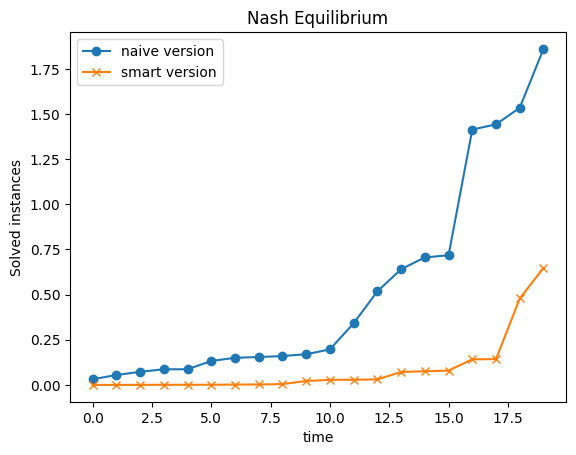

In [ ]:
# @title Cactus plot of results
if POINT_2 and EXPERIMENTS:
  from statistics import mean

  x_smart = results[0]
  y = [i for i in range(num_comparisons)]

  x_naive = results[1]

  x_smart.sort()
  x_naive.sort()
  print("Average time")
  print(f"\tsmart -> {mean(x_smart)}")
  print(f"\tsmart -> {mean(x_naive)}")

  print("Average of maximum strategy profiles to check")
  print(f"\tsmart -> {mean(results[2])}")
  print(f"\tnaive -> {mean(results[3])}")


  plt.plot(y, x_naive, marker='o', linestyle='-', label='naive version')
  plt.plot(y, x_smart,  marker='x', linestyle='-', label='smart version')

  plt.ylabel('Solved instances')
  plt.xlabel('time')
  plt.title('Nash Equilibrium')

  plt.legend()

  plt.show()

In [ ]:
#G = generate_random_graph_from_parameters(4, 1, 2, 2)
# nx.draw(G, with_labels = True, font_weight='bold', node_size = 500, node_color = 'red')
# all_nodes = list(G.nodes())
# all_nodes.remove('s')
# all_nodes.remove('t')
# all_strategy_profiles = powerset(all_nodes)
# always_cooperating_players = compute_always_cooperating_players(G)
# payoffs_smart = compute_payoffs(G, always_cooperating_players, True)
# #print(payoffs_smart)
# #print(always_cooperating_players)
# #nash_eq_smart = compute_nash_equilibrium_smart(G, payoffs_smart, always_cooperating_players, all_strategy_profiles, True)
# nash_eq_smart = compute_nash_equilibrium_naive(G, payoffs_smart, all_strategy_profiles, True)
# print(nash_eq_smart)


In [ ]:
# @title Block for checking solution after submission
# TODO just define your graph here and remove all comments
# if POINT_3 and SINGLE_BENCHMARK:
  # G=nx.Graph()
  # nodes = ['s', 't', '1', '2', '3', '4']
  # edges = [('s', '1'), ('s', '2'), ('1', '3'), ('1', '4'), #('3','4'),('3','2'),
  #         ('2', '4'), ('3', 't'), ('4', 't')]
  # G.add_nodes_from(nodes)
  # G.add_edges_from(edges)

  # print(f"Nodes: {G.nodes()}")
  # print(f"Edges: {G.edges()}")
  # all_nodes = list(G.nodes())
  # all_nodes.remove('s')
  # all_nodes.remove('t')
  # all_strategy_profiles = powerset(all_nodes)
  # always_cooperating_players = compute_always_cooperating_players(G)
  # payoffs_smart = compute_payoffs(G, always_cooperating_players, False)
  # nash_eq_smart = compute_nash_equilibrium_smart(G, payoffs_smart, always_cooperating_players, all_strategy_profiles)
  # print(nash_eq_smart)
  # payoffs_smart

# Assignment 3

In [ ]:
# @title Tree decomposition
if POINT_3:
  def tree_decomposition(G, elimination_order):
      bags: set = set()
      max_bag_size = 0
      for node in elimination_order:
          bag: set = set()
          bag.add(node)
          #triangulate - add an edge between any pair of adj nodes to the one that I am removing
          for neigh1 in nx.neighbors(G, node):
              #create a bag with all the neighbours of the elimination node
              bag.add(neigh1) #this should add the node itself
              for neigh2 in nx.neighbors(G, node):
                  G.add_edge(neigh1, neigh2)

          to_add = True
          for bag_already_added in bags:
              if  bag_already_added.issuperset(frozenset(bag)):
                  to_add = False

          if to_add:
              #add bag
              bags.add(frozenset(bag))
              if len(bag) > max_bag_size:
                  max_bag_size = len(bag)

          G.remove_node(node)

      # Build a weighted graph on the bags, where the weights are given by the cardinality of the intersection of any two bags
      # In such a way the maximum spanning tree of the constructed graph will trivially
      # coincide with the tree decomposition. No edge is added in T if the cardinality
      # of the intersection between two bags is not maximum(this comes form max span tree definition)
      cluster_graph = nx.Graph()
      edges = [(u, v, len(u & v)) for u, v in permutations(bags, 2) if len(u & v) > 0]
      cluster_graph.add_weighted_edges_from(edges)

      # Find the tree decomposition by extracting the maximum spanning tree of the cluster graph
      T = nx.maximum_spanning_tree(cluster_graph)

      return (max_bag_size-1, T)



In [ ]:
# @title min degree elimination order
if POINT_3:
  def min_degree_elimination_order(G):
      G1 = G.copy()
      degree_of_node:dict = {}
      removal_order = []
      min_neighbours_def = len(G1.nodes())
      while len(G1.nodes()) > 0:
          degree_of_node = {}
          min_neighbours = min_neighbours_def
          for node in G1.nodes():
              if G1.degree(node) < min_neighbours:
                  min_neighbours = G1.degree(node)
                  degree_of_node[node] = G1.degree(node)


          #G.remove_edges_from(G.nodes()[node])
          to_remove = list(degree_of_node.keys())[list(degree_of_node.values()).index(min(degree_of_node.values()))]
          removal_order.append(to_remove)
          #print("Nodes in the graph: ", G1.nodes(), " to remove ", to_remove)
          #triangulate - add an edge between any pair of adj nodes to the one that I am removing
          for neigh1 in nx.neighbors(G1, to_remove):
              for neigh2 in nx.neighbors(G1, to_remove):
                  if neigh1 != neigh2:
                    G1.add_edge(neigh1, neigh2)
          G1.remove_node(to_remove)
      return removal_order

In [ ]:
# @title Nash Equilibrium computation with Tree decomposition
# Note: whatever correct tree decomposition we find is a bound to the treewidth
# of the graph. The algorithm works with whatever tree decomposition, but in the
# trivial case in which all the nodes are grouped in a single bag the algorithm
# does not behave differently w.r.t. the nash equilibrium computation that does
# not exploit tree decomposition
if POINT_3:
  def compute_nash_equilibrium_from_tree_decomposition(T, payoffs, all_strategy_profiles):
    root = list(T.nodes())[0]
    bfs_successors = dict(nx.bfs_successors(T, root))
    postorder = nx.dfs_postorder_nodes(T, root)

    # keeps a set for each bag which consists of the players that a bag is fixing
    player_fixed_by_bag: dict = {}
    # keeps what are equilibria up to a certain level in the tree
    equilibria_up_to_bag : dict = {}

    players_fixed_cooperate = set()
    players_fixed_defect = set()
    non_fixed_players = set()

    for bag in postorder:
      #print(f"Considering bag {bag}")

      is_root = True
      #find the father of current bag and compute what node the current bag is fixing
      for father in bfs_successors:
        if bag in bfs_successors[father]:
          #bag is son of father
          is_root = False
          player_fixed_by_bag[bag] = bag - father
          #print(f"Bag {bag} is fixing  {player_fixed_by_bag[bag]} computed as {bag} - {father}")
          break
        if is_root:
          players_fixed_by_root = []
          # fix all the players that are in child and not in root
          for child in bfs_successors[bag]:
            # fix the players that were not fixed by child (those in common with them)
            players_fixed_by_root = players_fixed_by_root + list(child.intersection(bag))
          player_fixed_by_bag[bag] = frozenset(players_fixed_by_root)
          #print(f"Bag {bag} is fixing  {player_fixed_by_bag[bag]}")

      #leaf
      if bag not in bfs_successors:
        #print(f"bag {bag} is a leaf")
        equilibria_up_to_bag[bag] = []
        for strategy_profile in all_strategy_profiles:
          best_strategy = True
          for player in bag.union(non_fixed_players):
            #print(f"Checking best response for {player}")
            player_set = frozenset([player])

            if player in strategy_profile:
              changed_strategy = player_set - strategy_profile
            else:
              changed_strategy = strategy_profile.union(player_set)

            if payoffs[changed_strategy][int(player)-1] > payoffs[strategy_profile][int(player)-1]:
              best_strategy = False
              break
          #profile is not best strategy for some player and hence it cannot be an eq.
          #if no player stopped the inner for (for every player the profile was
          # a best response), then profile is an equilibrium
          if best_strategy:
            #just the players of the bag may suffice
            equilibria_up_to_bag[bag].append(strategy_profile)
            #print(f"appending equilibria for bag {bag}")

        # save fixed player by bag with their choice
        # (assuming that only one option is saved among cooperate and defect)
        for player in player_fixed_by_bag[bag]:
          all_defect = True
          all_cooperate = True
          for strategy in equilibria_up_to_bag[bag]:
            if player in strategy:
              all_defect = False
            if player not in strategy:
              all_cooperate = False
          if all_cooperate:
            players_fixed_cooperate.add(player)
            #print(f"Bag {bag} is fixing {player} as cooperate")
          elif all_defect:
            players_fixed_defect.add(player)
            #print(f"Bag {bag} is fixing {player} as defect")
          else: #non-fixed
            non_fixed_players.add(player)

      #non-leaf: merge results
      else:
        #print(f"bag {bag} is not a leaf")
        equilibria_up_to_bag[bag] = []
        all_strategy_profiles_bag = []

        # say that everyone survives
        for child in bfs_successors[bag]:
          #print(f"Considering bag {bag} - adding equilibria from {child}")
          all_strategy_profiles_bag = all_strategy_profiles_bag + equilibria_up_to_bag[child]

        to_check_players = players_fixed_cooperate.union(players_fixed_defect)
        strategy_profiles_to_remove = set()
        all_strategy_profiles_bag = list(set(all_strategy_profiles_bag))
        # remove strategy profiles such that they do not match on
        # he ith player with the ith player fixed by some child of bag
        #print(f"removing candidate eqilibria from bag {bag} I have to check players {players_fixed_cooperate} and {players_fixed_defect}")

        for strategy_profile in all_strategy_profiles_bag:
            for player in to_check_players:
              #print(f"I am in bag {bag} and checking {player}")
              if player in players_fixed_cooperate:
                if player not in strategy_profile:
                  strategy_profiles_to_remove.add(strategy_profile)
                  #print("Removed one")
                  #print(f"removed  {strategy_profile} outside bag loop - check cooperate")
              elif player in players_fixed_defect:
                if player in strategy_profile:
                  strategy_profiles_to_remove.add(strategy_profile)
                  #print(f"removed {strategy_profile} outside bag loop - check defect")
                  #print("Removed one")

        for strategy_profile in strategy_profiles_to_remove:
          all_strategy_profiles_bag.remove(strategy_profile)

        strategy_profiles_to_remove = set()

        for strategy_profile in all_strategy_profiles_bag:
          best_strategy = True
          for player in bag.union(non_fixed_players):
            player_set = frozenset([player])

            if player in strategy_profile:
              changed_strategy = player_set - strategy_profile
            else:
              changed_strategy = strategy_profile.union(player_set)

            if payoffs[changed_strategy][int(player)-1] > payoffs[strategy_profile][int(player)-1]:
              best_strategy = False
              strategy_profiles_to_remove.add(strategy_profile)
              #print("Removing inside check for bag best response")
              break

        for strategy_profile in strategy_profiles_to_remove:
          all_strategy_profiles_bag.remove(strategy_profile)

        equilibria_up_to_bag[bag] = all_strategy_profiles_bag

        # save fixed player by bag with their choice
        # (assuming that only one option is saved among cooperate and defect)
        for player in player_fixed_by_bag[bag]:
          all_defect = True
          all_cooperate = True
          for strategy in equilibria_up_to_bag[bag]:
            if player in strategy:
              all_defect = False
            if player not in strategy:
              all_cooperate = False
          if all_cooperate:
            players_fixed_cooperate.add(player)
            #print(f"Bag {bag} is fixing {player} as cooperate")
          elif all_defect:
            players_fixed_defect.add(player)
            #print(f"Bag {bag} is fixing {player} as defect")
          else: #non-fixed
            non_fixed_players.add(player)

      #print(f"Equilibria up to bag {bag} are {len(equilibria_up_to_bag[bag])}")
    return equilibria_up_to_bag[root]
    #original

frozenset({'4', '1'})
{frozenset({'4', '1'}): [frozenset({'3', '1'}), frozenset({'4', '2'})]}
equilibria are [frozenset({'3', '4', '2', '1'})]


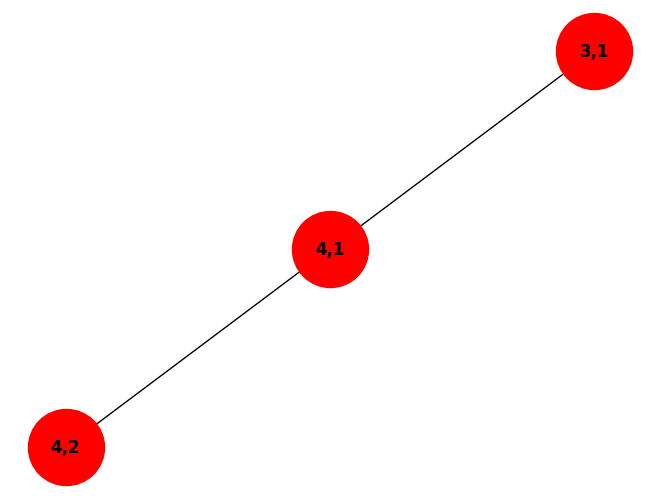

In [ ]:
if POINT_3 and EXPERIMENTS:

  G1 = G.copy()
  G1.remove_nodes_from(['s', 't'])
  T = tw.treewidth_min_degree(G1)[1]
  elim_order = min_degree_elimination_order(G1)

  #w, T = tree_decomposition(G1, elim_order)

  labels = {node:','.join(list(map(str, node))) for node in T}

  nx.draw(T, labels=labels, font_weight='bold', node_color = 'red', node_size = 3000)

  root = list(T.nodes())[0]
  print(root)
  bfs_successors = dict(nx.bfs_successors(T, root))
  print(bfs_successors)
  all_nodes = list(G.nodes())
  all_nodes.remove('s')
  all_nodes.remove('t')
  all_strategy_profiles = powerset(all_nodes)
  payoffs = compute_payoffs(G, [], True)
  all_equilibria = compute_nash_equilibrium_from_tree_decomposition(T, payoffs, all_strategy_profiles)
  print(f"equilibria are {all_equilibria}")
  #print(payoffs)

# Assignment 4

In [ ]:
# @title VCG
if POINT_4:
  # defines the function that maps each player to their real utility
  def real_utility_for_player(player: int):
    return player * 10

  # declare a random value close to the real utility of the player
  def declare_values(G):
    k = 9
    declared_values: dict = {}
    all_nodes = list(G.nodes())
    all_nodes.remove('s')
    all_nodes.remove('t')

    for player in all_nodes:
      true_value_for_player = real_utility_for_player(int(player))
      declared_values[player] = true_value_for_player + randint(-k, k)
    return declared_values

  # compute weight of a specific path according to declared values
  def get_weight(path, declared_values):
    value = 0
    for node in path[1:-1]:
      value += declared_values[node]
    return value

  # generate all simple paths in the graph and compute the weight of each of them
  def compute_paths_to_values(G, declared_values):
    paths_to_values = []
    for path in nx.all_simple_paths(G, 's', 't'):
      paths_to_values.append((path, get_weight(path, declared_values)))
    paths_to_values.sort(key=lambda tup: tup[1], reverse=True)
    return paths_to_values

  # compute top ranked option by excluding a player. If such player is None
  # just return the very first option (options are sorted by value)
  def compute_top_ranked_without_player(paths_to_values, excluded_player = None):
    if excluded_player is None:
      return paths_to_values[0]

    for path_and_value in paths_to_values:
      if excluded_player not in path_and_value[0]:
        return path_and_value

    #no path without excluded player
    return None

  # compute payements for all players given the declaration
  # in declared_values
  def VCG_mechanism(G, declared_values):
    #value and payements for every player
    VCG_results = {}
    paths_to_values = compute_paths_to_values(G, declared_values)
    # for i in paths_to_values:
    #   print(i)
    top_ranked = compute_top_ranked_without_player(paths_to_values)
    for player in list(G.nodes()):
      if player == 's' or player == 't':
        continue
      top_ranked_wo_player = compute_top_ranked_without_player(paths_to_values, excluded_player = player)
      if top_ranked_wo_player is None:
        h_i = 0
        #print(f"Top ranked path without player {player} has value 0")
      else:
        #print(f"Top ranked path without player {player} is {top_ranked_wo_player[0]} of value {top_ranked_wo_player[1]}")
        h_i = top_ranked_wo_player[1]
      opt_value_wo_player = 0
      for p in top_ranked[0][1:-1]:
        if p != player:
          opt_value_wo_player += declared_values[p]
      #print(f"sum values in opt without counting player {player} is of value: {opt_value_wo_player}")
      payement_player = h_i - opt_value_wo_player
      VCG_results[player] = payement_player * -1
    return VCG_results

  def compute_gain_with_payements_and_declarations(G, declared_values, players_and_payements):
    all_nodes = list(G.nodes())
    all_nodes.remove('s')
    all_nodes.remove('t')
    gain_players = {}
    for player in all_nodes:
      #print(f"payement for player {player} is:  {players_and_payements[player]}")
      gain_players[player] = players_and_payements[player] - declared_values[player]
    return gain_players

In [ ]:
if POINT_4:
    G =  generate_random_graph_from_parameters(7, 0.3, 2, 2)
    declared_values = declare_values(G)
    players_and_payements = VCG_mechanism(G, declared_values)
    compute_gain_with_payements_and_declarations(G, declared_values, players_and_payements)

In [ ]:
# @title Checking whether it is convenient for a player to declare a higher value
if POINT_4 and EXPERIMENTS:
  num_nodes = 7
  G =  generate_random_graph_from_parameters(num_nodes, 0.3, 2, 2)
  declared_values = declare_values(G)
  print(declared_values)

  increase_by_iteration = 5
  selected_changing_player = str(num_nodes//2)
  print(f"Selected changing player: {selected_changing_player}")
  declaration_for_player = []
  gain_for_changing_player = []

  for i in range(10):
    #change declaration of player and see what happens to the payement
    players_and_payements = VCG_mechanism(G, declared_values)
    gain_for_players = compute_gain_with_payements_and_declarations(G, declared_values, players_and_payements)
    declaration_for_player.append(declared_values[selected_changing_player])
    gain_for_changing_player.append(gain_for_players[selected_changing_player])
    #print("WE ", declared_values)
    #print(f"Players and payements {gain_for_players}")
    declared_values[selected_changing_player] += increase_by_iteration

  print(declaration_for_player)
  print(gain_for_changing_player)

{'1': 5, '2': 18, '3': 26, '4': 45, '5': 49, '6': 54, '7': 78}
Selected changing player: 3
[26, 31, 36, 41, 46, 51, 56, 61, 66, 71]
[-26, -31, -36, -41, -46, -51, -56, -61, -66, -71]


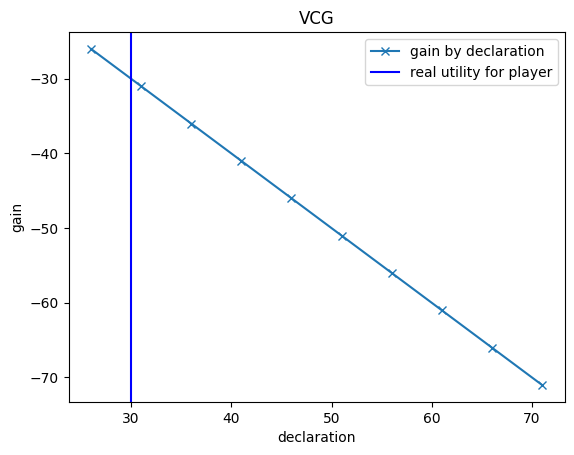

In [ ]:
# @title Plot how gain for player goes as his declared value increases
if POINT_4 and EXPERIMENTS:
  plt.plot(declaration_for_player, gain_for_changing_player,  marker='x', linestyle='-', label='gain by declaration')
  plt.axvline(x = real_utility_for_player(int(selected_changing_player)), color = 'b', label = 'real utility for player')
  plt.ylabel('gain')
  plt.xlabel('declaration')
  plt.title('VCG')

  plt.legend()

  plt.show()

In [ ]:
# @title Block for checking solution after submission
# TODO just define your graph here and remove all comments
# if POINT_3 and SINGLE_BENCHMARK:
  # G=nx.Graph()
  # nodes = ['s', 't', '1', '2', '3', '4']
  # edges = [('s', '1'), ('s', '2'), ('1', '3'), ('1', '4'), #('3','4'),('3','2'),
  #         ('2', '4'), ('3', 't'), ('4', 't')]
  # G.add_nodes_from(nodes)
  # G.add_edges_from(edges)
  # declared_values = declare_values(G)
  # print(declared_values)
  # players_and_payements = VCG_mechanism(G, declared_values)
  # compute_gain_with_payements_and_declarations(G, declared_values, players_and_payements)